In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import torch
from sqnet import SQNet, jacobian, hessian
import numpy as np
from utils import solve_crocoddyl, random_array, griddata
from data import crocoddyl_gradient
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
net = torch.load('sqnet.pth')

In [19]:
def network_gradient(net, xtest):
    cost = net(torch.tensor(xtest, dtype=torch.float32)).detach().numpy().reshape(-1,1)
    
    true_gradient      = []
    approx_hessian     = []
    true_hessian       = []

    states = torch.tensor(xtest, dtype=torch.float32)
    
    for state in states:
        
        state.requires_grad = True
        
        # True gradient
        grad = jacobian(net(state), state)
        true_gradient.append(grad.detach().numpy())
        #print(grad)
        
        # True Hessian
        _hessian = hessian(net(state), state).detach().numpy()
        true_hessian.append(_hessian)
        #print(_hessian)
        
        # Estimating from Jacobian
        newton = grad.T @ grad
        newton_hessian = newton.detach().numpy()
        approx_hessian.append(np.linalg.norm(newton_hessian))

        
    true_gradient    =  np.array(true_gradient).squeeze()
    true_hessian     =  np.array(true_hessian).squeeze()
    
    return cost, true_gradient, true_hessian




def crocoddyl_hessians(xtest):
    solutions = []
    for xyz in xtest:
        ddp = solve_crocoddyl(xyz)
        solutions.append(ddp)


    vx    = []
    vxx   = []
    cost  = []


    for ddp in solutions:
        
        diff1  = np.array(ddp.Vx)
        diff2  = np.array(ddp.Vxx)

        vx.append(diff1[0])
        vxx.append(diff2[0])

        cost.append([ddp.cost])



    vx    = np.array(vx)
    vxx   = np.array(vxx)
    cost  = np.array(cost).reshape(-1,1)
    return cost, vx, vxx

In [20]:
x = 0.99
y = np.linspace(-1., 1., 100)
xtest = np.array([ [x,x2, 0.] for x2 in y ])


In [21]:
cost_pred, net_gradient, net_hessian = network_gradient(net, xtest)
cost, vx, vxx = crocoddyl_hessians(xtest)

In [40]:
vxx_dy2 = []
for i in vxx:
    a = np.diagonal(i)
    vxx_dy2.append([a[1]])

In [46]:
net_dy2 = []
for i in net_hessian:
    a = np.diagonal(i)
    net_dy2.append([a[1]])

Text(0.5, 1.0, 'd2c/dy^2')

<Figure size 432x288 with 0 Axes>

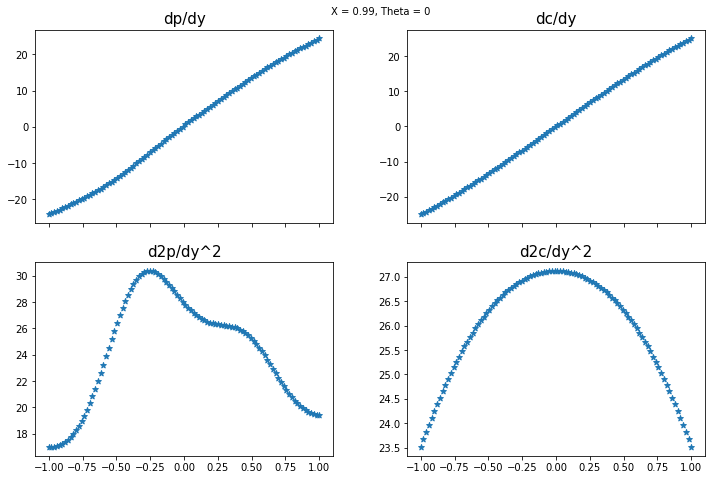

In [47]:
        
plt.clf()

# Make the figure:

fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
fig.suptitle("X = 0.99, Theta = 0", fontsize = 10)
fig.subplots_adjust(left=0.02, bottom=0.2, right=0.95, top=0.94, wspace=0.25)

# Plot prediction, cost
im1 = axs[0, 1].scatter(xtest[:,1], y = vx[:,1], marker = "*")
im2 = axs[0, 0].scatter(xtest[:,1], y = net_gradient[:,1], marker = "*")

im3 = axs[1, 1].scatter(xtest[:,1], y = vxx_dy2, marker = "*")
im4 = axs[1, 0].scatter(xtest[:,1], y = net_dy2, marker = "*")

axs[0, 0].set_title("dp/dy", fontsize  = 15)
axs[0, 1].set_title("dc/dy", fontsize  = 15)
axs[1, 0].set_title("d2p/dy^2", fontsize  = 15)
axs[1, 1].set_title("d2c/dy^2", fontsize  = 15)
